In [1]:
from amftrack.pipeline.functions.transport_processing.high_mag_videos.loading import load_video_dataset_local
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%load_ext autoreload
%autoreload 2
plt.style.use('presentation.mplstyle')
%matplotlib widget
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 100


c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
analysis_folder = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\CocoTransport\KymoSpeeDExtract"
analysis_folder_root = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\CocoTransport\KymoSpeeDExtract/"
# analysis_folder = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\CocoCut\KymoSpeeDExtract"
# analysis_folder_root = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\CocoCut\KymoSpeeDExtract/"

videos_folder = "/projects/0/einf914/videos/"


In [5]:
indexes = {
"20250110_Plate009" : "20230818_1107_Plate10",
"20250111_Plate009" : "20230818_1107_Plate10",
"20250112_Plate009" : "20230818_1107_Plate10",
    
}

In [6]:
all_infos = pd.DataFrame()

for plate_id_video in list(indexes.keys()):
    print(plate_id_video)
    data_obj = load_video_dataset_local(plate_id_video, videos_folder, analysis_folder, analysis_folder_root)
    for index, vid_obj in enumerate(data_obj.video_objs):
        if os.path.exists(vid_obj.edge_adr):
            plt.close("all")
            edge_data_csv = pd.read_csv(vid_obj.edge_adr)
            edge_data_csv['mode'] = vid_obj.dataset['mode']
            edge_data_csv['xpos'] = vid_obj.dataset['xpos']
            edge_data_csv['ypos'] = vid_obj.dataset['ypos']
            edge_data_csv['plate_id'] = vid_obj.dataset['plate_id']
            edge_data_csv['video_int'] = vid_obj.dataset['video_int']
            edge_data_csv['record_time'] = vid_obj.dataset["record_time"]
            all_infos = pd.concat([all_infos,edge_data_csv])
    # break

20250110_Plate009
20250111_Plate009
20250112_Plate009


In [21]:
all_infos.columns

Index(['Unnamed: 0', 'edge_name', 'edge_length', 'straight_length',
       'speed_max', 'speed_min', 'speed_mean', 'flux_avg', 'flux_min',
       'flux_max', 'flux_left', 'flux_right', 'speed_left', 'speed_right',
       'speed_left_std', 'speed_right_std', 'coverage_left', 'coverage_right',
       'coverage_tot', 'edge_xpos_1', 'edge_ypos_1', 'edge_xpos_2',
       'edge_ypos_2', 'mode', 'xpos', 'ypos', 'plate_id', 'video_int',
       'record_time', 'distance', 'is_anchor'],
      dtype='object')

In [18]:
anchor_video_int_map = {
    "20250110_Plate9": 2,
    "20250111_Plate9": 1,
    "20250112_Plate9": 1
}


In [19]:
# Create a boolean column to identify anchor rows based on the map
df['is_anchor'] = df.apply(
    lambda row: row['video_int'] == anchor_video_int_map[row['plate_id']],
    axis=1
)

# Extract the anchor rows
df_anchor = df[df['is_anchor']].set_index('plate_id')

# Create a mapping from plate_id to anchor xpos, ypos
anchor_x_map = df_anchor['xpos'].to_dict()
anchor_y_map = df_anchor['ypos'].to_dict()


# Create a mapping from plate_id to anchor xpos, ypos
anchor_x_map = df_anchor['xpos'].to_dict()
anchor_y_map = df_anchor['ypos'].to_dict()
df['anchor_x'] = df['plate_id'].map(anchor_x_map)
df['anchor_y'] = df['plate_id'].map(anchor_y_map)
# Distance from the anchor point
df['distance'] = np.sqrt((df['xpos'] - df['anchor_x'])**2 +
                         (df['ypos'] - df['anchor_y'])**2)
# If you do not need anchor_x and anchor_y anymore:
df.drop(columns=['anchor_x', 'anchor_y'], inplace=True)


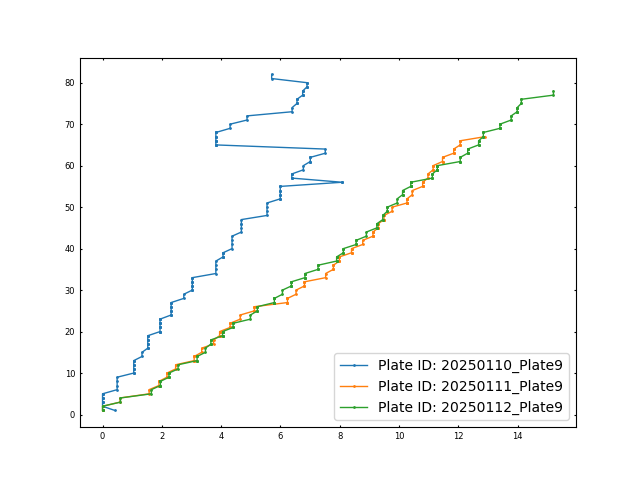

In [20]:
import matplotlib.pyplot as plt

# Grouping the data by plate_id for separate plots
plate_ids = df['plate_id'].unique()
fig,ax = plt.subplots()
# Plotting video_int vs. distance for each plate_id
for plate_id in plate_ids:
    subset = df[df['plate_id'] == plate_id]
    ax.plot(subset['distance'], subset['video_int'], marker='o', linestyle='-', label=f'Plate ID: {plate_id}')
    # plt.xlabel('Distance to Anchor (units)')
    # plt.ylabel('Video Number (video_int)')
    plt.legend()
    # plt.grid(True)
    # plt.show()


In [26]:
import numpy as np
import pandas as pd
from itertools import combinations

# Example starting DataFrame
# df has columns:
# ['Unnamed: 0', 'edge_name', 'edge_length', 'straight_length',
#  'speed_max', 'speed_min', 'speed_mean', 'flux_avg', 'flux_min',
#  'flux_max', 'flux_left', 'flux_right', 'speed_left', 'speed_right',
#  'speed_left_std', 'speed_right_std', 'coverage_left', 'coverage_right',
#  'coverage_tot', 'edge_xpos_1', 'edge_ypos_1', 'edge_xpos_2',
#  'edge_ypos_2', 'mode', 'xpos', 'ypos', 'plate_id', 'video_int',
#  'record_time', 'distance', 'is_anchor']

###############################################################################
# 1) Compute the vectors and angles
###############################################################################

df['vector_x'] = df['edge_xpos_2'] - df['edge_xpos_1']
df['vector_y'] = df['edge_ypos_2'] - df['edge_ypos_1']
df['angle'] = np.arctan2(df['vector_y'], df['vector_x'])

###############################################################################
# 2) Define a helper function to pick the two most aligned edges in a group
###############################################################################

def pick_two_most_aligned(group):
    """
    If group size <= 3, return it as is.
    If group size > 3, find the pair of rows that have the smallest angular difference
    and return only those two rows.
    """
    if len(group) <= 2:
        return group
    
    angles = group['angle'].values
    # We will search all pairs and find the one with the minimal angular difference
    best_diff = float('inf')
    best_pair = (None, None)
    
    # Check all combinations of edges within the group
    for i, j in combinations(range(len(angles)), 2):
        diff = abs(angles[i] - angles[j])%np.pi
        # Because angles wrap around at 2*pi, account for that:
        # diff = min(diff, np.pi - diff)
        
        if diff < best_diff:
            best_diff = diff
            best_pair = (i, j)
    
    # Return only the two rows corresponding to best_pair
    # group.iloc[...] uses the positional indices within this group
    return group.iloc[list(best_pair)]

###############################################################################
# 3) Apply the function groupwise and collect the results
###############################################################################

df_two_aligned = (
    df
    .groupby(['video_int', 'plate_id'], group_keys=False)
    .apply(pick_two_most_aligned)
    .reset_index(drop=True)
)

# df_two_aligned now contains only the edges you want:
#   - If a group had <=3 edges, all are included.
#   - If a group had >3 edges, only the 2 most aligned are kept.


In [27]:
df_two_aligned[df_two_aligned['video_int']==25]

,Unnamed: 0,edge_name,edge_length,straight_length,speed_max,speed_min,speed_mean,flux_avg,flux_min,flux_max,...,xpos,ypos,plate_id,video_int,record_time,distance,is_anchor,vector_x,vector_y,angle
115,0,"(2, 0)",62.928,64.471408,7.063169,-11.074825,0.533936,13.474549,-85.547930,108.748761,...,25.455,-2.870,20250110_Plate9,25,13:39:14,2.313398,False,-916.0,-277.0,-2.847934
116,0,"(5, 2)",40.434,40.653826,4.950088,-29.741640,1.550036,68.994430,-51.700057,240.468330,...,25.455,-2.870,20250110_Plate9,25,13:39:14,2.313398,False,-576.0,-109.0,-2.954568
117,0,"(26, 2)",62.652,66.072175,5.486918,-10.848741,0.600122,16.976462,-111.851555,128.125891,...,25.323,-4.919,20250111_Plate9,25,13:51:30,5.121635,False,-953.0,-330.0,-2.808240
118,0,"(43, 26)",35.880,37.532448,6.507851,-10.739149,-0.064191,-0.719651,-135.876831,119.450318,...,25.323,-4.919,20250111_Plate9,25,13:51:30,5.121635,False,-496.0,-191.0,-2.774014
119,0,"(10, 0)",52.440,55.293244,14.364985,-3.997189,-1.449234,-43.698158,-139.482300,59.869048,...,25.059,-4.815,20250112_Plate9,25,17:06:45,5.221491,False,-778.0,-327.0,-2.743702
120,0,"(27, 10)",50.370,52.805516,11.633927,-5.027485,-1.056085,-29.721901,-137.496434,81.855931,...,25.059,-4.815,20250112_Plate9,25,17:06:45,5.221491,False,-715.0,-259.0,-2.794057


In [51]:
df_two_aligned = df_two_aligned[
    ~((df_two_aligned['plate_id'] == '20250110_Plate9') & (df_two_aligned['video_int'] > 55))]
df_two_aligned = df_two_aligned[
~((df_two_aligned['plate_id'] == '20250111_Plate9') & (df_two_aligned['video_int'] > 52))]

(-8.0, 8.0)

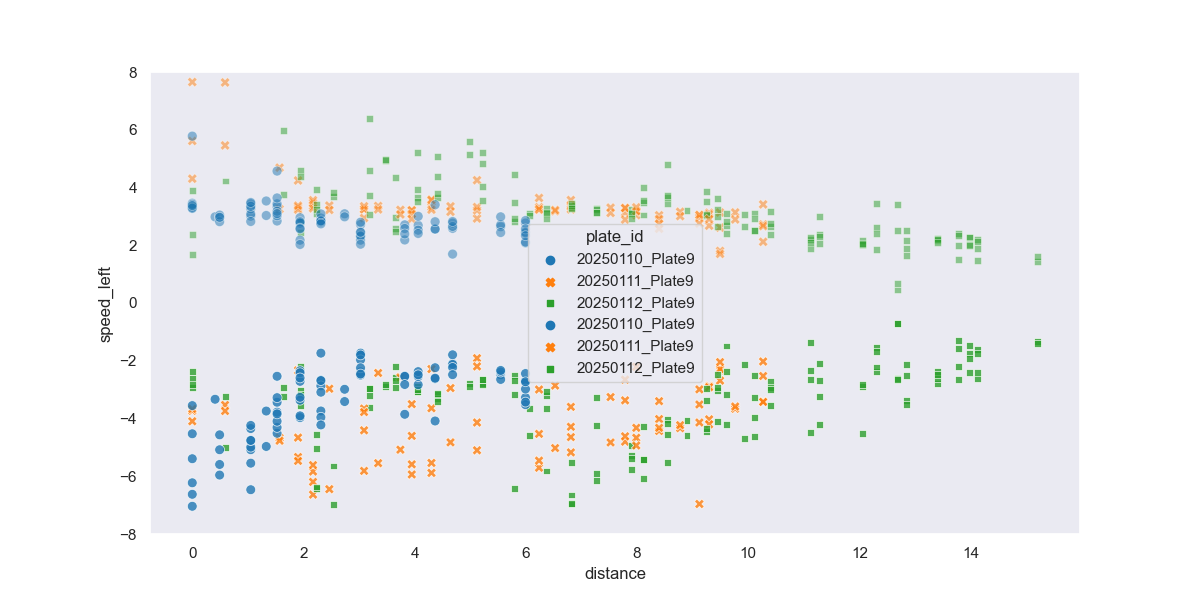

In [55]:
import seaborn as sns

import matplotlib.pyplot as plt



# Set up a seaborn style for better visual aesthetics

sns.set(style="dark")



# Create a scatterplot to show speed_left and speed_right as functions of distance, separated by plate_id

plt.figure(figsize=(12, 6))

sns.scatterplot(
    data=df_two_aligned,
    x='distance',
    y='speed_left',
    hue='plate_id',
    style='plate_id',
    markers=True,
    palette="tab10",
    s=50,  # Adjust marker size
    alpha=0.8  # Add some transparency for better visibility
)



sns.scatterplot(
    data=df_two_aligned,
    x='distance',
    y='speed_right',
    hue='plate_id',
    style='plate_id',
    markers=True,
    palette="tab10",
    s=50,  # Adjust marker size
    alpha=0.5  # Add transparency for differentiation
)

plt.ylim(-8,8)


In [56]:
brightfields = df_two_aligned[df_two_aligned['mode']=="BF"]

C:\Users\coren\AppData\Local\Temp\ipykernel_6440\2391578887.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brightfields['distance_max'] = brightfields.groupby('plate_id')['distance'].transform('max')
C:\Users\coren\AppData\Local\Temp\ipykernel_6440\2391578887.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brightfields['adjusted_distance'] = brightfields['distance_max'] - brightfields['distance']


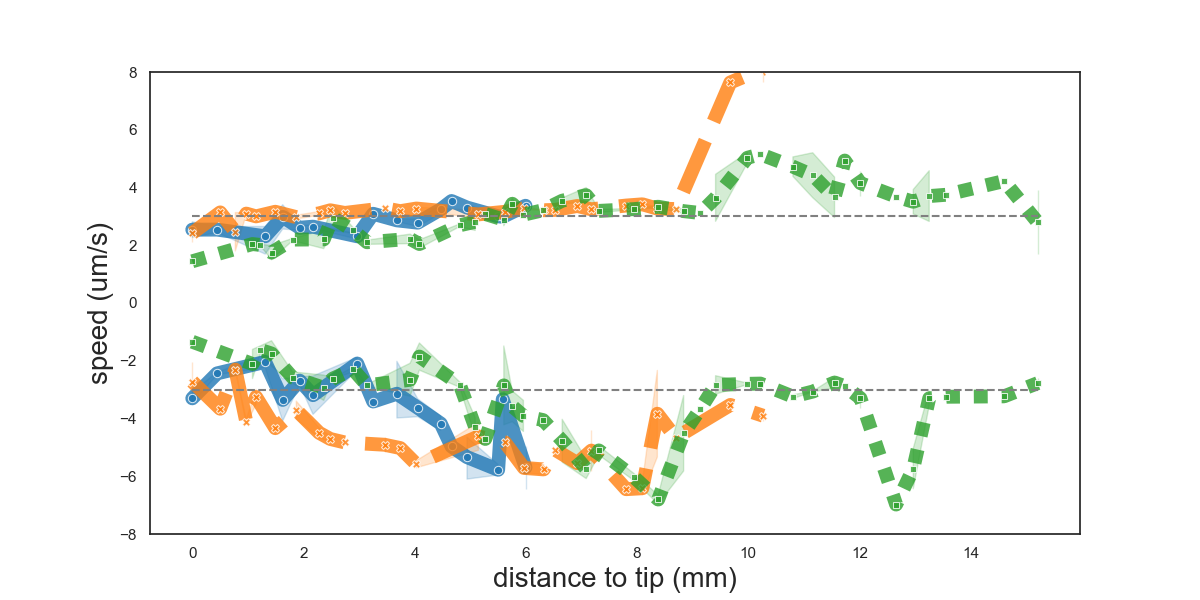

In [145]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `brightfields` is your DataFrame
# Calculate distance_max - distance for each plate_id
brightfields['distance_max'] = brightfields.groupby('plate_id')['distance'].transform('max')
brightfields['adjusted_distance'] = brightfields['distance_max'] - brightfields['distance']

# Plotting
plt.figure(figsize=(12, 6))

# Lineplot for speed_left
sns.lineplot(
    data=brightfields,
    x='adjusted_distance',
    y='speed_left',
    hue='plate_id',
    style='plate_id',
    markers=True,
    palette="tab10",
    alpha=0.8,
    linewidth = 10
    
)

# Lineplot for speed_right
sns.lineplot(
    data=brightfields,
    x='adjusted_distance',
    y='speed_right',
    hue='plate_id',
    style='plate_id',
    markers=True,
    palette="tab10",
    alpha=0.8,
    linewidth = 10
    
)

# Add horizontal lines at y=3 and y=-3
plt.hlines(3, 0, brightfields['adjusted_distance'].max(), colors='gray', linestyles='dashed')
plt.hlines(-3, 0, brightfields['adjusted_distance'].max(), colors='gray', linestyles='dashed')

# Adjust plot limits and legend
plt.ylim(-8, 8)
plt.legend().remove()
plt.ylabel('speed (um/s)',size = 20)

plt.xlabel('distance to tip (mm)',size = 20)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
plt.show()


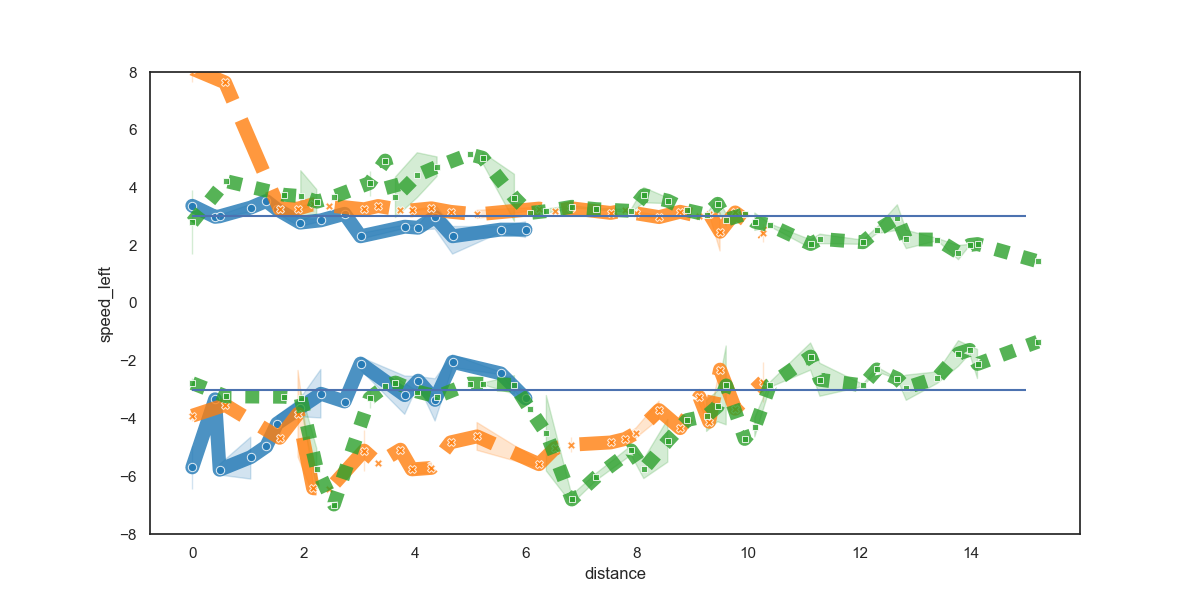

In [144]:
import seaborn as sns

import matplotlib.pyplot as plt



# Set up a seaborn style for better visual aesthetics

# sns.set(style="whitegrid")



# Create a scatterplot to show speed_left and speed_right as functions of distance, separated by plate_id

plt.figure(figsize=(12, 6))

sns.lineplot(
    data=brightfields,
    x='distance',
    y='speed_left',
    hue='plate_id',
    style='plate_id',
    markers=True,
    palette="tab10",
    # s=50,  # Adjust marker size
    alpha=0.8,  # Add some transparency for better visibility
    linewidth = 10
    
)



sns.lineplot(
    data=brightfields,
    x='distance',
    y='speed_right',
    hue='plate_id',
    style='plate_id',
    markers=True,
    palette="tab10",
    # s=50,  # Adjust marker size
    alpha=0.8,  # Add transparency for differentiation
    linewidth = 10
    
    
)
plt.hlines(3,0,15)
plt.hlines(-3,0,15)

plt.ylim(-8,8)
plt.legend().remove()

C:\Users\coren\AppData\Local\Temp\ipykernel_6440\3717096874.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fluorescence['distance_max'] = fluorescence.groupby('plate_id')['distance'].transform('max')
C:\Users\coren\AppData\Local\Temp\ipykernel_6440\3717096874.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fluorescence['adjusted_distance'] = fluorescence['distance_max'] - fluorescence['distance']


(-0.5, 0.5)

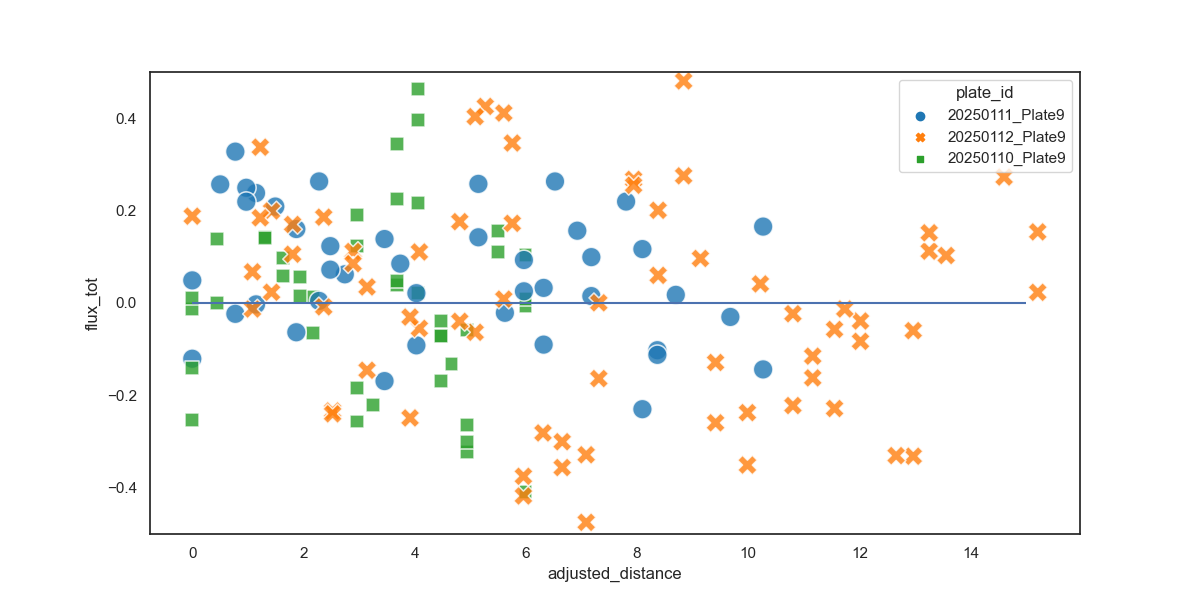

In [151]:
df_two_aligned['flux_tot'] = (df_two_aligned["flux_right"]+df_two_aligned["flux_left"])/(np.abs(df_two_aligned["flux_right"])+np.abs(df_two_aligned["flux_left"]))
fluorescence = df_two_aligned[df_two_aligned['mode']=="F"]

fluorescence['distance_max'] = fluorescence.groupby('plate_id')['distance'].transform('max')
fluorescence['adjusted_distance'] = fluorescence['distance_max'] - fluorescence['distance']

plt.figure(figsize=(12, 6))

sns.scatterplot(
    data=fluorescence,
    x='adjusted_distance',
    y='flux_tot',
    hue='plate_id',
    style='plate_id',
    markers=True,
    palette="tab10",
    s=200,  # Adjust marker size
    alpha=0.8  # Add some transparency for better visibility
)
plt.hlines(0,0,15)

plt.ylim(-0.5,0.5)

(-0.5, 0.5)

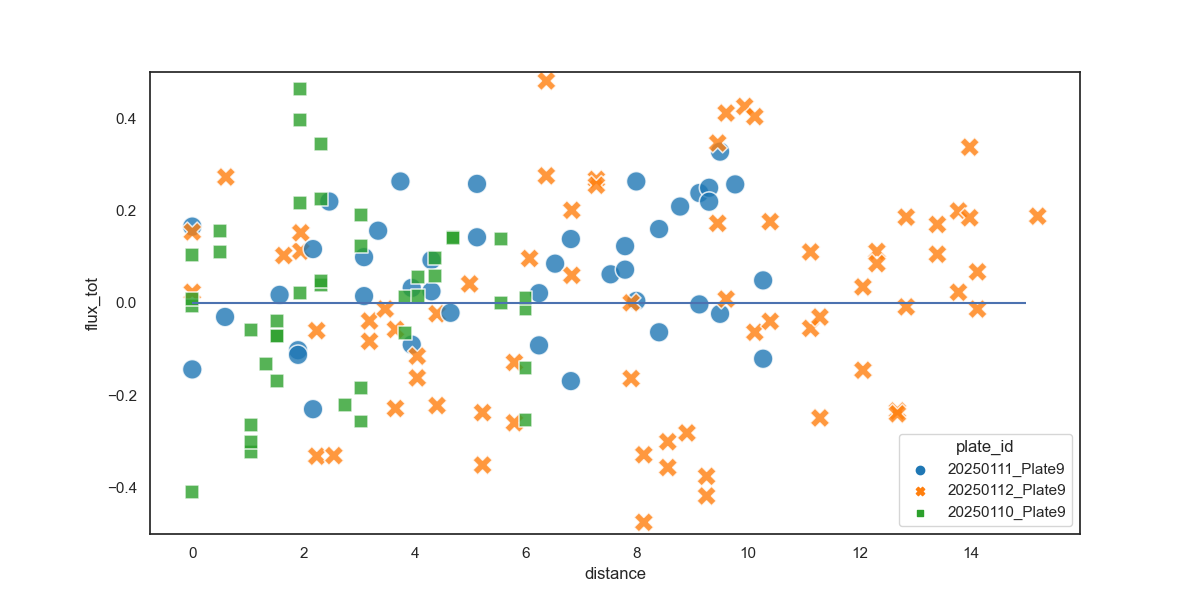

In [149]:

plt.figure(figsize=(12, 6))

sns.scatterplot(
    data=fluorescence,
    x='distance',
    y='flux_tot',
    hue='plate_id',
    style='plate_id',
    markers=True,
    palette="tab10",
    s=200,  # Adjust marker size
    alpha=0.8  # Add some transparency for better visibility
)
plt.hlines(0,0,15)

plt.ylim(-0.5,0.5)

C:\Users\coren\AppData\Local\Temp\ipykernel_6440\2309230502.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brightfields['distance_max'] = brightfields.groupby('plate_id')['distance'].transform('max')
C:\Users\coren\AppData\Local\Temp\ipykernel_6440\2309230502.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brightfields['adjusted_distance'] = brightfields['distance_max'] - brightfields['distance']
C:\Users\coren\AppData\Local\Temp\ipykernel_6440\2309230502.py:20: SettingWithCopyWarning: 
A value i

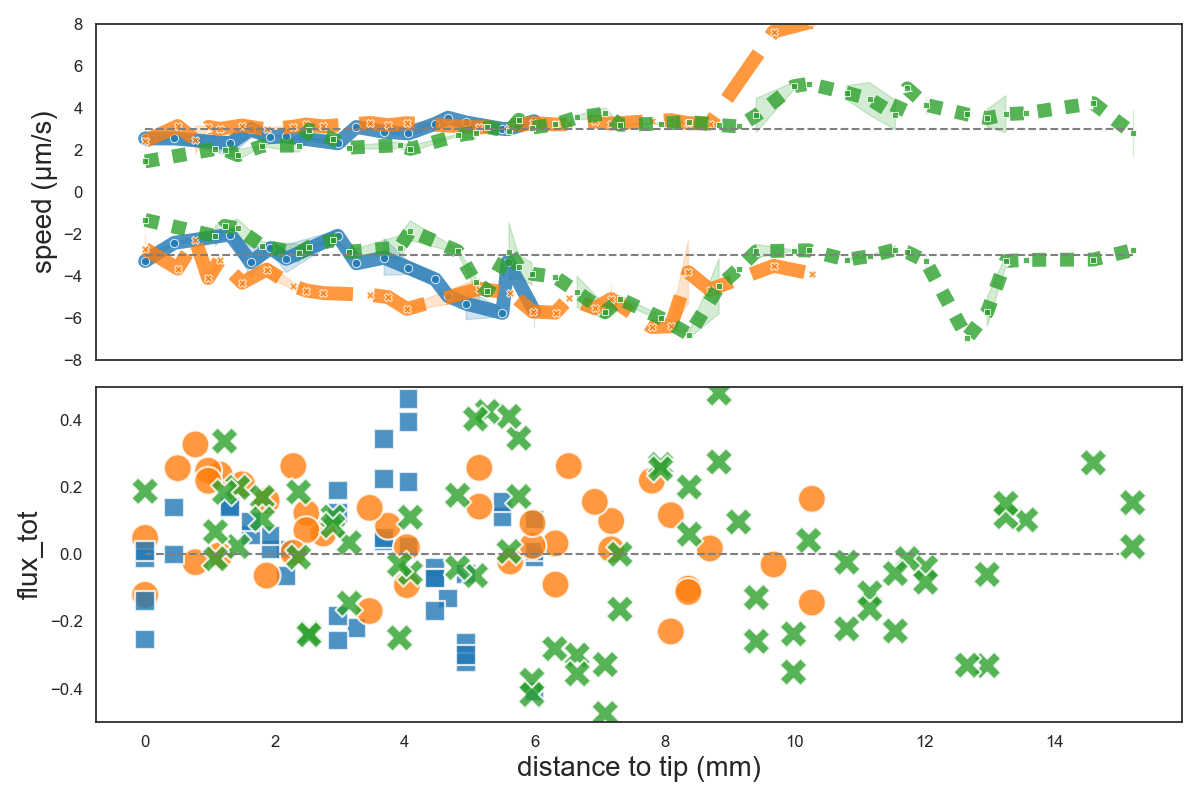

In [155]:
unique_plate_ids = pd.concat([brightfields['plate_id'], fluorescence['plate_id']]).unique()
shared_palette = sns.color_palette("tab10", n_colors=len(unique_plate_ids))
color_mapping = {plate_id: color for plate_id, color in zip(unique_plate_ids, shared_palette)}

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `brightfields` and `df_two_aligned` are your DataFrames

# Process brightfields DataFrame
brightfields['distance_max'] = brightfields.groupby('plate_id')['distance'].transform('max')
brightfields['adjusted_distance'] = brightfields['distance_max'] - brightfields['distance']

# Process df_two_aligned DataFrame for fluorescence
df_two_aligned['flux_tot'] = (df_two_aligned["flux_right"] + df_two_aligned["flux_left"]) / \
                             (np.abs(df_two_aligned["flux_right"]) + np.abs(df_two_aligned["flux_left"]))
fluorescence = df_two_aligned[df_two_aligned['mode'] == "F"]
fluorescence['distance_max'] = fluorescence.groupby('plate_id')['distance'].transform('max')
fluorescence['adjusted_distance'] = fluorescence['distance_max'] - fluorescence['distance']

# Create a shared x-axis plot
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot 1: Speed vs Adjusted Distance
sns.lineplot(
    data=brightfields,
    x='adjusted_distance',
    y='speed_left',
    hue='plate_id',
    style='plate_id',
    markers=True,
    palette=color_mapping,
    alpha=0.8,
    linewidth=10,
    ax=ax[0]
)
sns.lineplot(
    data=brightfields,
    x='adjusted_distance',
    y='speed_right',
    hue='plate_id',
    style='plate_id',
    markers=True,
    palette=color_mapping,
    alpha=0.8,
    linewidth=10,
    ax=ax[0]
)
ax[0].hlines(3, 0, brightfields['adjusted_distance'].max(), colors='gray', linestyles='dashed')
ax[0].hlines(-3, 0, brightfields['adjusted_distance'].max(), colors='gray', linestyles='dashed')
ax[0].set_ylim(-8, 8)
ax[0].legend().remove()
ax[0].set_ylabel('speed (µm/s)', size=20)
ax[0].tick_params(axis='y', labelsize=12)

# Plot 2: Flux Total vs Adjusted Distance
sns.scatterplot(
    data=fluorescence,
    x='adjusted_distance',
    y='flux_tot',
    hue='plate_id',
    style='plate_id',
    markers=True,
    palette=color_mapping,
    s=400,
    alpha=0.8,
    ax=ax[1]
)
ax[1].hlines(0, 0, 15, colors='gray', linestyles='dashed')
ax[1].set_ylim(-0.5, 0.5)
ax[1].legend().remove()
ax[1].set_ylabel('flux_tot', size=20)
ax[1].set_xlabel('distance to tip (mm)', size=20)
ax[1].tick_params(axis='x', labelsize=12)
ax[1].tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()


In [61]:
vlipid = 3 #um.s
v_growth = 250/3600
rho0 = v_growth / vlipid
rho0

0.02314814814814815

In [72]:
v_growth

0.06944444444444445

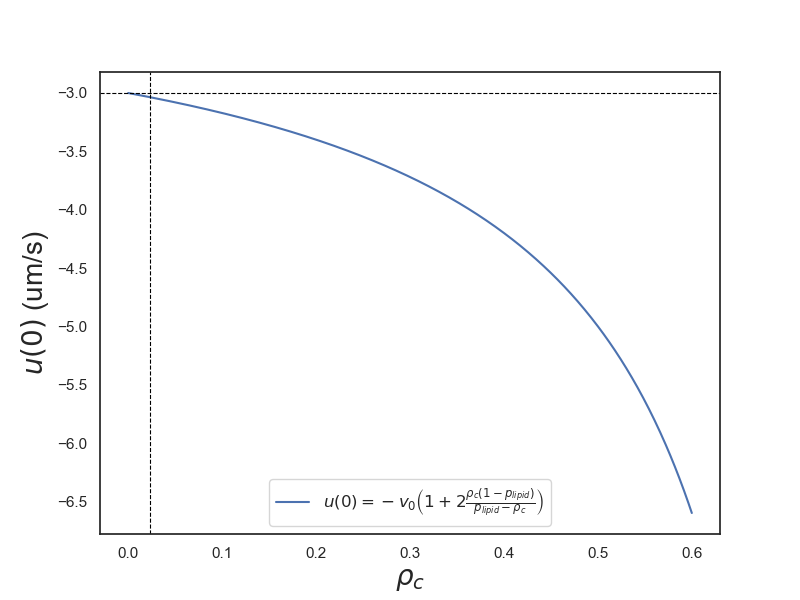

In [123]:
import numpy as np
import matplotlib.pyplot as plt
sns.set(style="white")

# Constants
v0 = 3  # Assuming v0 = 1 for simplicity
plipid = 0.8  # Given

# Function definition
def u(rho_c):
    return -v0 * (1 + 2 * (rho_c * (1 - plipid)) / (plipid - rho_c))

# Range of rho_c
rho_c_values = np.linspace(0, 0.6, 500)
u_values = u(rho_c_values)

# Plotting the function
plt.figure(figsize=(8, 6))
plt.plot(rho_c_values, u_values, label=r'$u(0) = -v_0 \left( 1 + 2 \frac{\rho_c (1 - p_{lipid})}{p_{lipid} - \rho_c} \right)$')
plt.xlabel(r'$\rho_c$', fontsize=20)
plt.ylabel(r'$u(0)$ (um/s)', fontsize=20)
# plt.title(r'Plot of $u(0)$ as a function of $\rho_c$', fontsize=16)
plt.axhline(-v0, color='black', linestyle='--', linewidth=0.8)
plt.axvline(rho0, color='black', linestyle='--', linewidth=0.8)
plt.legend(fontsize=12)
plt.show()


In [83]:
np.power(8,1/3)

2.0

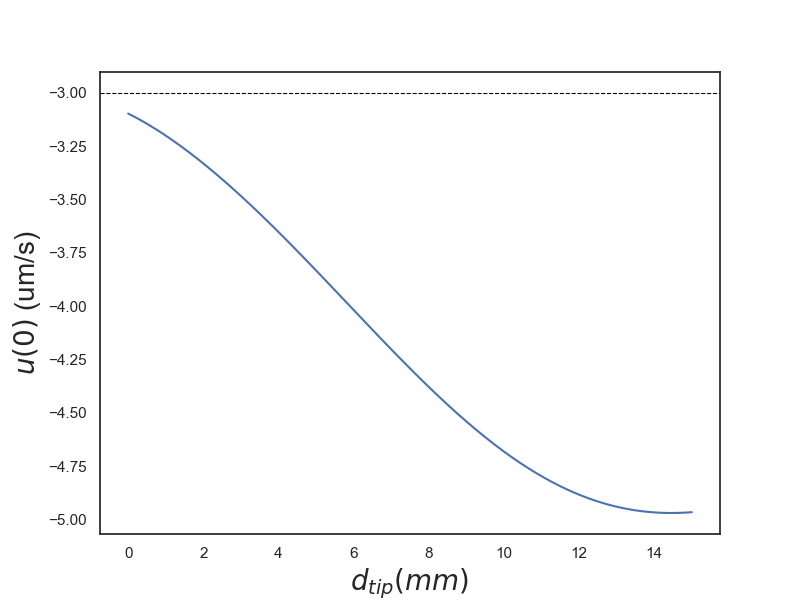

In [134]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
v0 = 3  # Assuming v0 = 1 for simplicity
plipid = 0.6  # Given

# Function definition
def u(rho_c):
    return -v0 * (1+2 * (rho_c * (1 - plipid)) / (plipid - rho_c))

# Range of rho_c
d_values = np.linspace (0,15,500)
d_branch = 1
R_ratio = np.minimum(np.power(1.2,1/3)**(d_values/d_branch),4)

# rho_c_values = rho0 * (1.4**(d_values/d_branch))/(R_ratio**2)
# rho_c_values = rho0 * (1+d_values/d_branch)
rho_c_values = rho0 * (1+d_values/d_branch/2)**2/(R_ratio**2)
# rho_c_values = rho0 * (1+d_values/d_branch)/(R_ratio**2)

u_values = u(rho_c_values)

# Plotting the function
plt.figure(figsize=(8, 6))
plt.plot(d_values, u_values, label=r'$u(0) = -v_0 \left( 1 + 2 \frac{\rho_c (1 - p_{lipid})}{p_{lipid} - \rho_c} \right)$')
plt.xlabel(r'$d_{tip} (mm)$', fontsize=20)
plt.ylabel(r'$u(0)$ (um/s)', fontsize=20)
# plt.title(r'Plot of $u(0)$ as a function of $\rho_c$', fontsize=16)
plt.axhline(-v0, color='black', linestyle='--', linewidth=0.8)
# plt.legend(fontsize=12)
plt.show()


In [5]:
x_pos_init = all_infos.loc[all_infos['video_int'] == 1, 'xpos'].iloc[0]
y_pos_init = all_infos.loc[all_infos['video_int'] == 1, 'ypos'].iloc[0]

# Calculate distance for video_int < 87
mask = all_infos['video_int'] < 87
all_infos.loc[mask, 'dist_init'] = np.sqrt((all_infos.loc[mask, 'ypos'] - y_pos_init) ** 2 +
                                           (all_infos.loc[mask, 'xpos'] - x_pos_init) ** 2)

# Second initial positions for video_int >= 89
x_pos_init = all_infos.loc[all_infos['video_int'] == 89, 'xpos'].iloc[0]
y_pos_init = all_infos.loc[all_infos['video_int'] == 89, 'ypos'].iloc[0]

# Calculate distance for video_int >= 89
mask = all_infos['video_int'] >= 89
all_infos.loc[mask, 'dist_init'] = np.sqrt((all_infos.loc[mask, 'ypos'] - y_pos_init) ** 2 +
                                           (all_infos.loc[mask, 'xpos'] - x_pos_init) ** 2)
all_infos['dist_init'] = all_infos['dist_init'].fillna(-1)
factor = 100
all_infos['dist_init'] = (all_infos['dist_init']*factor).astype(int)/factor

In [22]:
list1 = range(1,42)
list2 = range(45,87)
list3 = range(89,131)
list4 = range(133,153)
def determine_group(value):
    if value in list1:
        return 1
    elif value in list2:
        return 2
    elif value in list3:
        return 3
    elif value in list4:
        return 4
    else:
        return -1

# Apply the function to the DataFrame
all_infos['group'] = all_infos['video_int'].apply(determine_group)
all_infos['group'] = (all_infos['group']+1)//2

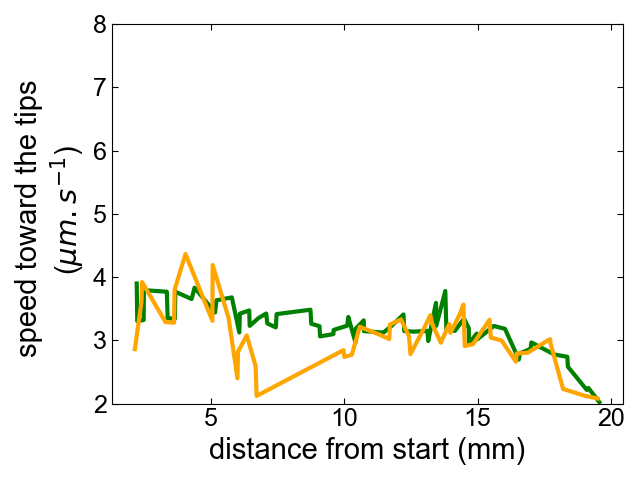

In [25]:
fig,ax = plt.subplots()
select= all_infos[all_infos['group'].isin([1,2])]
select = select[select['coverage_tot']>0.1]
select = select[select['edge_length']>20]
select = select[select['speed_right']<=4.5]
select = select[select['speed_right']>=2]

select = select[select['dist_init']>=2]
palette = {0:"blue",1:"green",2:"orange",3:"red",4:"orange"}


# sns.scatterplot(select,x='dist_init',y="speed_right",alpha = 1,hue="group",palette="viridis")

sns.lineplot(select,x='dist_init',y="speed_right",alpha = 1,hue="group",palette=palette,estimator="max",errorbar=None)
# sns.scatterplot(select,x='dist_init',y="speed_left",alpha = 1,hue="group",palette="viridis")

# sns.lineplot(select,x='dist_init',y="speed_left",alpha = 1,hue="group",palette="viridis",estimator="min",errorbar=None)
ax.set_xlabel("distance from start (mm)") #Not really mm...
ax.set_ylabel("speed toward the tips \n ($\mu m.s^{-1}$)") #Not really mm...
ax.set_ylim(2,8)
ax. get_legend().set_visible(False)
plt.tight_layout()


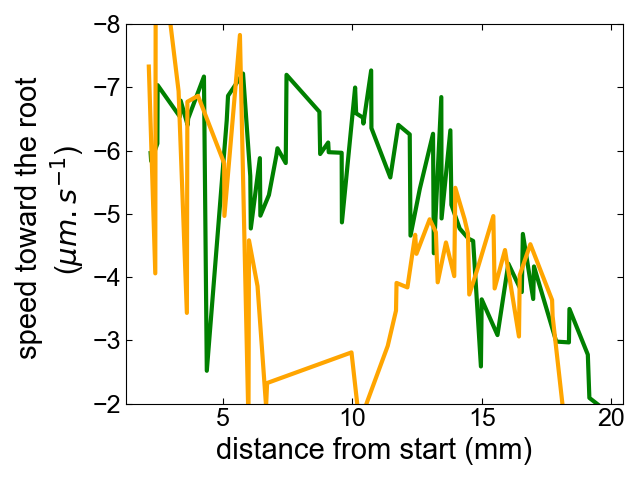

In [26]:
fig,ax = plt.subplots()
select= all_infos[all_infos['group'].isin([1,2])]
select = select[select['coverage_tot']>0.1]
select = select[select['edge_length']>20]
select = select[select['speed_right']<=4.5]
select = select[select['speed_right']>=2]
select = select[select['speed_left']<=-1.5]


select = select[select['dist_init']>=2]



# sns.scatterplot(select,x='dist_init',y="speed_right",alpha = 1,hue="group",palette="viridis")

sns.lineplot(select,x='dist_init',y="speed_left",alpha = 1,hue="group",palette=palette,estimator="max",errorbar=None)
# sns.scatterplot(select,x='dist_init',y="speed_left",alpha = 1,hue="group",palette="viridis")

# sns.lineplot(select,x='dist_init',y="speed_left",alpha = 1,hue="group",palette="viridis",estimator="min",errorbar=None)
ax.set_xlabel("distance from start (mm)") #Not really mm...
ax.set_ylabel("speed toward the root \n ($\mu m.s^{-1}$)") #Not really mm...

ax. get_legend().set_visible(False)
ax.set_ylim(-2,-8)

plt.tight_layout()


<AxesSubplot: xlabel='dist_init', ylabel='speed_right'>

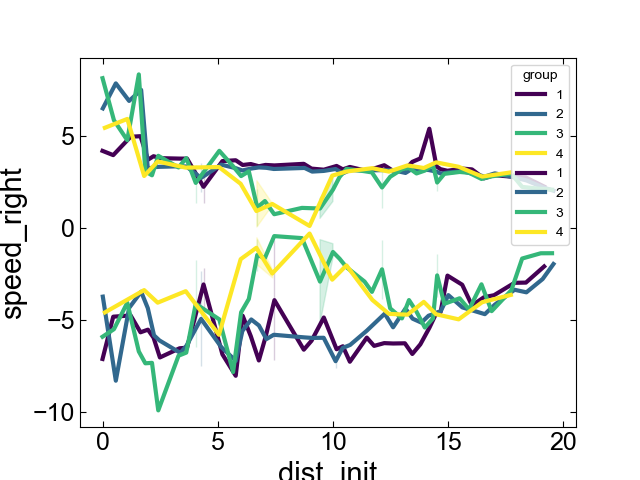

In [54]:
fig,ax = plt.subplots()
select= all_infos[all_infos['group'].isin([1,2,3,4])]
select = select[select['coverage_tot']>0.1]
select = select[select['edge_length']>20]
select = select[select['speed_left']>=-10]



sns.lineplot(select,x='dist_init',y="speed_right",alpha = 1,hue="group",palette="viridis")
sns.lineplot(select,x='dist_init',y="speed_left",alpha = 1,hue="group",palette="viridis")



In [40]:
all_infos['load'] = all_infos['betweenness_automate']/all_infos['width_automate']**2
all_infos['diff_left'] = np.abs(np.abs(all_infos['speed_left']) - 3.15)
all_infos['diff_right'] = np.abs(np.abs(all_infos['speed_right']) - 3.15)

# Assign 'speed_lipid' and 'speed_other' based on which speed is closer to 3.15
all_infos['speed_lipid'] = np.where(all_infos['diff_left'] <= all_infos['diff_right'], all_infos['speed_left'], all_infos['speed_right'])
all_infos['speed_other'] = np.where(all_infos['diff_left'] > all_infos['diff_right'], all_infos['speed_left'], all_infos['speed_right'])
all_infos['speed_other_abs'] = np.abs(all_infos['speed_other'])
all_infos['speed_main'] = np.where(all_infos['coverage_left'] > all_infos['coverage_right'], all_infos['speed_left'], all_infos['speed_right'])
all_infos['speed_sub'] = np.where(all_infos['coverage_left'] > all_infos['coverage_right'], all_infos['speed_right'], all_infos['speed_left'])
all_infos['speed_sub_abs'] = np.abs(all_infos['speed_sub'])

all_infos['speed_main_abs'] = np.abs(all_infos['speed_main'])
all_infos['coverage_main'] = np.where(all_infos['coverage_left'] > all_infos['coverage_right'], all_infos['coverage_left'], all_infos['coverage_right'])

# Drop the intermediate 'diff_left' and 'diff_right' columns if they are no longer needed
all_infos = all_infos.drop(['diff_left', 'diff_right'], axis=1)

In [41]:
all_infos.columns

Index(['Unnamed: 0', 'edge_name', 'edge_length', 'straight_length',
       'speed_max', 'speed_min', 'speed_mean', 'flux_avg', 'flux_min',
       'flux_max', 'speed_left', 'speed_right', 'speed_left_std',
       'speed_right_std', 'coverage_left', 'coverage_right', 'coverage_tot',
       'edge_xpos_1', 'edge_ypos_1', 'edge_xpos_2', 'edge_ypos_2', 'mode',
       'xpos', 'ypos', 'plate_id', 'Unnamed: 0.1', 'network_end',
       'network_begin', 'mapping_quality', 'width_automate',
       'betweenness_automate', 'betweenness_derivative', 'load', 'speed_lipid',
       'speed_other', 'speed_other_abs', 'speed_main', 'speed_sub',
       'speed_sub_abs', 'speed_main_abs', 'coverage_main'],
      dtype='object')

In [42]:
infos_F = all_infos.loc[all_infos['mode']=='F']
infos_F.drop(['edge_length','straight_length',"network_end","network_begin","mapping_quality","width_automate","betweenness_automate","load","mode"],axis = 1)
infos_BF = all_infos.loc[all_infos['mode']=='BF']
infos_BF = infos_BF.drop(['mode'], axis=1)
merged_df = infos_F.merge(infos_BF,on = ["xpos","ypos","plate_id","network_end","network_begin"],suffixes=("F","BF"))

In [ ]:
all_infos['uniquepos'] = all_infos['xpos'].astype(str)+all_infos['ypos'].astype(str)+all_infos['plate_id']+all_infos['network_end'].astype(str)++all_infos['network_begin'].astype(str)
len(all_infos),len(all_infos['uniquepos'].unique())

In [ ]:
len(merged_df)

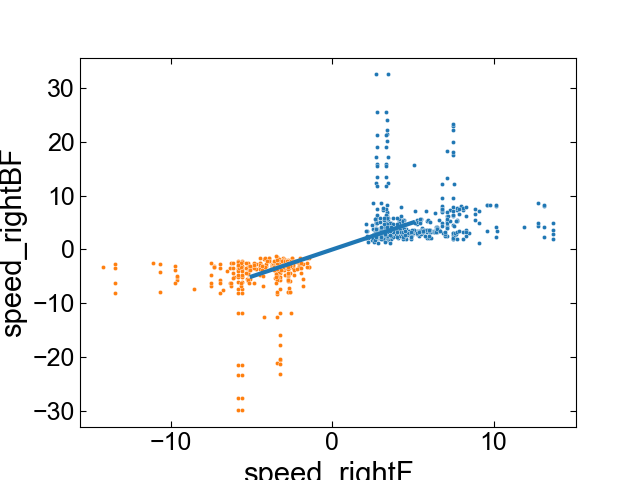

In [17]:
fig,ax = plt.subplots()
select = merged_df[merged_df['coverage_rightF']>merged_df['coverage_leftF']]
select = select[select['coverage_rightF']>0.1]

select = select[select['speed_rightF']<15]

sns.scatterplot(select,x='speed_rightF',y="speed_rightBF",alpha = 1)
select = merged_df[merged_df['coverage_leftF']>merged_df['coverage_rightF']]
select = select[select['coverage_leftF']>0.1]

select = select[select['speed_leftF']>-15]

sns.scatterplot(select,x='speed_leftF',y="speed_leftBF",alpha = 1)
ax.plot([-5,5],[-5,5])

In [43]:
merged_df['speed_lipid'] = np.where(merged_df['coverage_leftF'] > merged_df['coverage_rightF'], merged_df['speed_leftBF'], merged_df['speed_rightBF'])
merged_df['speed_other'] = np.where(merged_df['coverage_leftF'] > merged_df['coverage_rightF'], merged_df['speed_rightBF'], merged_df['speed_leftBF'])
merged_df['speed_lipid2'] = np.where(merged_df['flux_avgF'] < 0, merged_df['speed_leftBF'], merged_df['speed_rightBF'])
merged_df['speed_other2'] = np.where(merged_df['flux_avgF'] < 0, merged_df['speed_rightBF'], merged_df['speed_leftBF'])
merged_df['abs_speed_lipid2'] = np.abs(merged_df['speed_lipid2'])
merged_df['abs_speed_other2'] = np.abs(merged_df['speed_other2'])


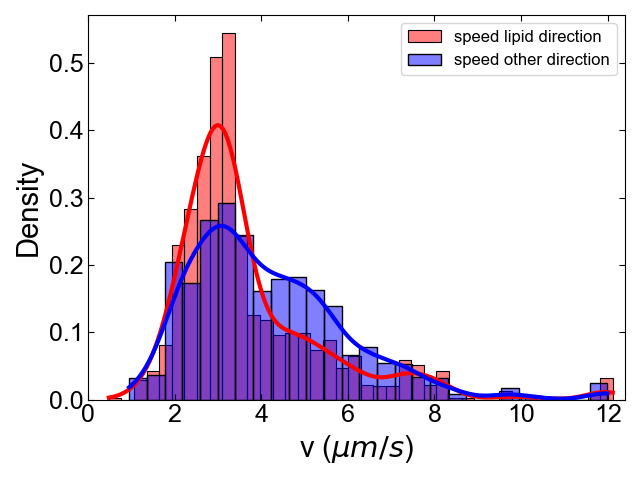

In [47]:
select = merged_df
fig,ax = plt.subplots()
select = select[select['coverage_totBF']>0.05]

sns.histplot(np.abs(select['speed_lipid']),color='red',stat="density",kde=True,label = "speed lipid direction")
sns.histplot(np.abs(select['speed_other']),color='blue',stat="density",kde=True,label = "speed other direction")
ax.legend(fontsize='large')
ax.set_xlabel("v ($\mu m/s$)")
ax.set_xlim(0,12.4)
plt.tight_layout()

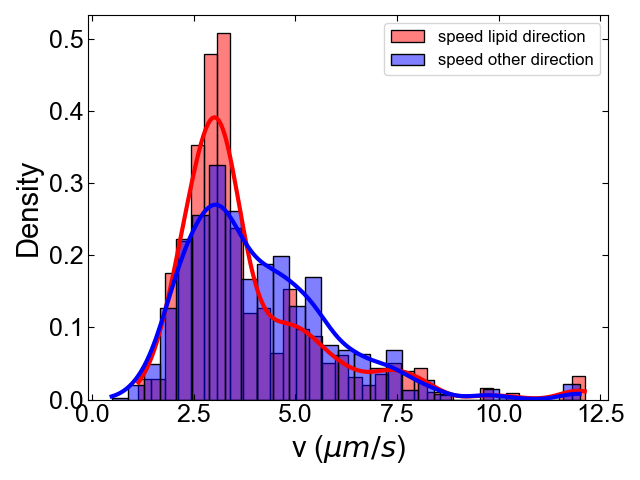

In [20]:
select = merged_df
fig,ax = plt.subplots()
select = select[select['coverage_totBF']>0.05]

sns.histplot(np.abs(select['speed_lipid2']),color='red',stat="density",kde=True,label = "speed lipid direction")
sns.histplot(np.abs(select['speed_other2']),color='blue',stat="density",kde=True,label = "speed other direction")
ax.legend(fontsize='large')
ax.set_xlabel("v ($\mu m/s$)")
plt.tight_layout()

In [ ]:
all_infos_sub.columns

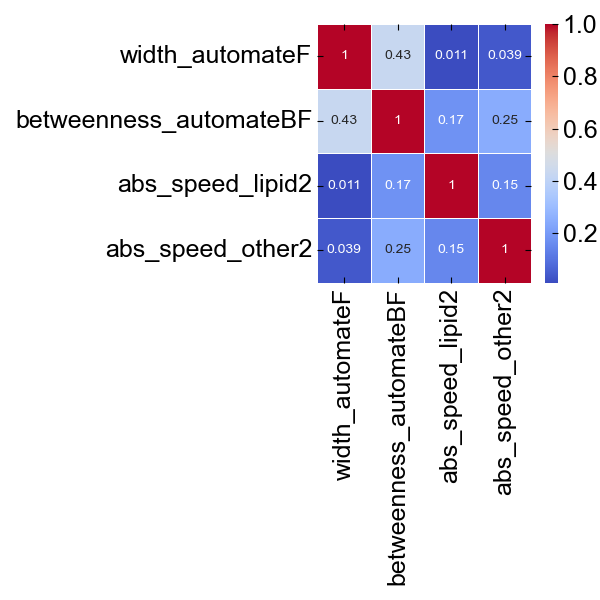

In [35]:
fig,ax = plt.subplots(figsize = (6,6))
all_infos_sub = merged_df[merged_df['plate_id']=='20230905_Plate310']
select = all_infos_sub

select = select[select['coverage_totBF']>0.05]
select = select[select['speed_rightBF']<=15]
select = select[select['speed_lipid2']<=15]

selected_columns = select[['width_automateF',"betweenness_automateBF",'abs_speed_lipid2','abs_speed_other2']]

# Calculating Pearson correlation matrix
correlation_matrix = selected_columns.corr()

# Creating the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.tight_layout()

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Assuming merged_df is your initial DataFrame

# Step 1: Parse the Date from plate_id and add it as a new column
merged_df['date'] = pd.to_datetime(merged_df['plate_id'].str.split('_').str[0], format='%Y%m%d')

# Number of bootstrap samples
n_bootstraps = 1000

# Initialize a dictionary to store correlation dataframes for each pair
correlations_dict = {}
uncertainty_dict = {}
dates = []
for date, group in merged_df.groupby('date'):
    dates.append(date)
    select = group[(group['coverage_totBF'] > 0.05) & 
                   (group['speed_rightBF'] <= 15) & 
                    (group['mapping_qualityBF'] <= 15) &
                   
                   (group['speed_lipid2'] <= 15)]
    
    selected_columns = select[['width_automateF', "betweenness_automateBF", 'abs_speed_lipid2', 'abs_speed_other2']]
    correlation_matrix = selected_columns.corr()

    # Iterate through the correlation matrix to update our dictionaries
    for row in correlation_matrix.index:
        for col in correlation_matrix.columns:
            if row >= col:  # Avoid duplicating pairs and self-correlations
                continue
            key = f"{row} vs {col}"
            
            # Perform bootstrap resampling for the pair
            bootstrapped_corrs = []
            for _ in range(n_bootstraps):
                bootstrap_sample = selected_columns[[row, col]].sample(n=select.shape[0], replace=True)
                corr = bootstrap_sample.corr().iloc[0, 1]
                bootstrapped_corrs.append(corr)
            
            # Calculate mean and 95% confidence interval
            mean_corr = np.mean(bootstrapped_corrs)
            lower_bound = np.percentile(bootstrapped_corrs, 2.5)
            upper_bound = np.percentile(bootstrapped_corrs, 97.5)
            
            # Update correlations_dict
            if key not in correlations_dict:
                correlations_dict[key] = pd.DataFrame(columns=['date', 'correlation'])
            temp_df = pd.DataFrame({'date': [date], 'correlation': [mean_corr]})
            correlations_dict[key] = pd.concat([correlations_dict[key], temp_df], ignore_index=True)
            
            # Update uncertainty_dict
            if key not in uncertainty_dict:
                uncertainty_dict[key] = pd.DataFrame(columns=['date', 'lower', 'upper'])
            temp_uncertainty_df = pd.DataFrame({'date': [date], 'lower': [lower_bound], 'upper': [upper_bound]})
            uncertainty_dict[key] = pd.concat([uncertainty_dict[key], temp_uncertainty_df], ignore_index=True)


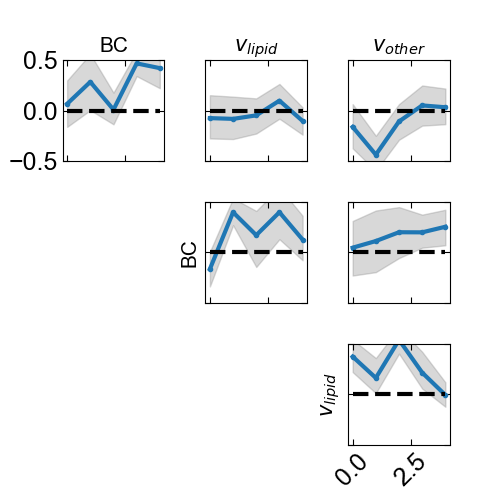

In [37]:
import matplotlib.pyplot as plt

# Assuming we have 4 variables, leading to a 3x3 grid of correlations (excluding self-correlations)
variables = ['width_automateF', 'betweenness_automateBF', 'abs_speed_lipid2', 'abs_speed_other2']
variable_names = ['$r$', 'BC', '$v_{lipid}$', '$v_{other}$']
# First, calculate the minimum date to use as a baseline

# Convert the date differences from the minimum date into days
# This involves first converting the timedelta results into 'timedelta64[D]' to get days,
# and then converting to integers.


n = len(variables)

# Create a figure and axes in a grid
fig, axs = plt.subplots(n-1, n-1, figsize=(5, 5), sharex='col', sharey='row')
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Function to find the corresponding dataframe for a given pair
def find_df_for_pair(row_var, col_var):
    for key in correlations_dict:
        if row_var in key and col_var in key:
            return correlations_dict[key].sort_values('date'), uncertainty_dict[key].sort_values('date')
    return None, None

# Plotting in a matrix layout
for i in range(n-1):
    for j in range(i+1, n):
        row_var = variables[i]
        col_var = variables[j]
        correlation_df, uncertainty_df = find_df_for_pair(row_var, col_var)
        min_date = np.min(correlation_df['date'])
        correlation_df['days_since_min'] = (correlation_df['date'] - min_date).dt.days
        uncertainty_df['days_since_min'] = (uncertainty_df['date'] - min_date).dt.days
        if correlation_df is not None and uncertainty_df is not None:
            axs[i, j-1].plot(correlation_df['days_since_min'], correlation_df['correlation'], marker='o', label=f'{row_var} vs {col_var}')
            axs[i, j-1].fill_between(uncertainty_df['days_since_min'], uncertainty_df['lower'], uncertainty_df['upper'], color='gray', alpha=0.3)
            # axs[i, j-1].set_title(f'{row_var} vs {col_var}')
            # axs[i, j-1].grid(True)
            # axs[i, j-1].legend()

# Adjusting labels for clarity
for ax, col_var in zip(axs[0], variable_names[1:]):
    ax.set_title(col_var,fontdict = {"fontsize" : 15})
for ax, row_var,date in zip(axs[:,0], variable_names[:-1],dates):
    ax.set_ylim(-0.5,0.5)

for j in range(n-1):
    # Assuming we're sharing x-axis, we only need to adjust the last row
    axs[n-2, j].tick_params(axis='x', labelrotation=45)  # Rotate x-axis labels to 45 degrees

for i in range(n-1):
    for j in range(n-1):
        # Now explicitly skipping lower triangle plots by hiding those axes
        if i > j:
            axs[i, j].axis('off')  # This hides the axes in the lower triangle and the diagonal
        else:
            axs[i, j].hlines(0,0,4,color="black",linestyle="dashed")
        if i==j:
            axs[i, j].set_ylabel(variable_names[:-1][i], rotation=90, size=15)
            
            
  

# plt.tight_layout()
plt.show()


<AxesSubplot: xlabel='coverage_right', ylabel='coverage_left'>

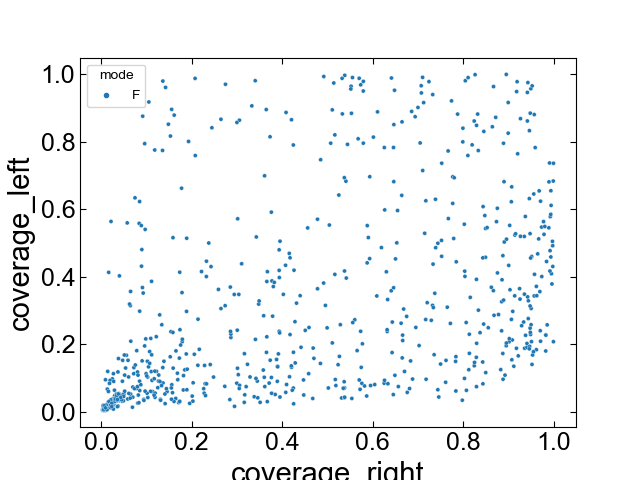

In [25]:
fig,ax = plt.subplots()

select = all_infos[all_infos['mode']=="F"]
# select = select[select['coverage_tot']>0.1]
select = select[select['speed_right']<=15]

sns.scatterplot(select,x='coverage_right',y="coverage_left",alpha = 1,hue="mode")
# sns.scatterplot(select,x='coverage_left',y="speed_left",alpha = 0.2,hue="mode")

In [ ]:
import seaborn as sns
thresh_F = 0.05
fig,ax = plt.subplots()
# select = all_infos[all_infos['mode']=="F"]
# select = select[select['coverage_right']>thresh_F]
# select = select[select['speed_right']<=15]

# sns.histplot(select['speed_right'],stat="density",kde=True,color='blue')
# # sns.histplot(select['speed_left'],stat="density",kde=True,color='blue')
# select = all_infos[all_infos['mode']=="F"]
# select = select[select['coverage_left']>thresh_F]
# select = select[select['speed_right']<=15]

# sns.histplot(select['speed_left'],stat="density",kde=True,color='blue')
select = all_infos[all_infos['mode']=="F"]
select = select[select['coverage_main']>0.05]

select = select[select['speed_right']<=15]
selectp = select[select['speed_main']>0]
selectm = select[select['speed_main']<0]

sns.histplot(selectp['speed_main'],stat="density",color='blue')
sns.histplot(selectm['speed_main'],stat="density",color='blue')

# sns.histplot(select['speed_left'])
select = all_infos[all_infos['mode']=="BF"]
select = select[select['coverage_tot']>0.05]
select = select[select['speed_right']<=15]
sns.histplot(select['speed_right'],stat="density",kde=True,color='red')
sns.histplot(select['speed_left'],stat="density",kde=True,color='red')

# sns.histplot(select['speed_left'])


In [ ]:
fig,ax = plt.subplots(figsize = (6,6))
select = all_infos[all_infos['coverage_tot']>0.05]
select = select[select['mode']=="BF"]

select = select[select['speed_right']<=15]
sns.histplot(select['speed_main'],stat="density",kde=True,color='blue')
sns.histplot(select['speed_sub'],stat="density",kde=True,color='red')

In [ ]:
fig,ax = plt.subplots(figsize = (6,6))
select = all_infos[all_infos['coverage_tot']>0.05]
select = select[select['speed_right']<=15]

sns.scatterplot(select,x='speed_main',y="speed_sub",alpha = 0.2,hue="mode")

In [ ]:
fig,ax = plt.subplots(figsize = (6,6))
all_infos_sub = all_infos[all_infos['plate_id']=='20230903_Plate310']

select = all_infos_sub[all_infos_sub['mode']=="BF"]
select = select[select['coverage_tot']>0.05]
select = select[select['speed_right']<=15]
sns.scatterplot(select,x='load',y="speed_sub_abs")

In [ ]:
sns.scatterplot(select,x='load',y="speed_left")

In [ ]:
fig,ax = plt.subplots(figsize = (3,3))

sns.scatterplot(select,x='betweenness_automate',y="speed_other_abs")

In [ ]:
fig,ax = plt.subplots(figsize = (6,6))
all_infos_sub = all_infos[all_infos['plate_id']=='20230902_Plate310']
select = all_infos_sub[all_infos_sub['mode']=="BF"]

select = select[select['coverage_tot']>0.05]
select = select[select['speed_right']<=15]
selected_columns = select[['width_automate','betweenness_automate','load','speed_main_abs','speed_sub_abs','speed_left', 'speed_right']]

# Calculating Pearson correlation matrix
correlation_matrix = selected_columns.corr()

# Creating the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
# plt.tight_layout()

In [ ]:
import matplotlib.pyplot as plt
selected_columns = select[['width_automate', 'speed_left', 'speed_right','betweenness_automate','load']]

# Calculating Pearson correlation matrix
correlation_matrix = selected_columns.corr()

# Creating the heatmap
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)